# Introduction

Transfer learning is a well-established technique for training artificial neural networks (see e.g., Ref. [2]), which is based on the general intuition that if a pre-trained network is good at solving a given problem, then, with just a bit of additional training, it can also be used to solve a different but related problem.

As discussed in Ref. [1], this idea can be formalized in terms of two abstract networks ***A*** and ***B***, independently from their quantum or classical physical nature.

<img src = "./img/architecture.png" height = 300px>

As sketched in the above figure, one can give the following general definition of the transfer learning method:

1. Take a network ***A*** that has been pre-trained on a dataset ***D<sub>A</sub>*** and for a given task ***T<sub>A</sub>***.

2. Remove some of the final layers. In this way, the resulting truncated network ***A′*** can be used as a feature extractor.

3. Connect a new trainable network ***B*** at the end of the pre-trained network ***A′***.

4. Keep the weights of ***A′*** constant, and train the final block ***B*** with a new dataset ***D<sub>B</sub>*** and/or for a new task of interest ***T<sub>B</sub>***.

When dealing with hybrid systems, depending on the physical nature (classical or quantum) of the networks **A** and **B**, one can have different implementations of transfer learning as summarized in the following table:

| Network A | Network B | Transfer Learning Scheme |
|-----------|-----------|--------------------------|
| Classical | Classical | CC - Standard classical method. See e.g., Ref. [2]. |
| Classical | Quantum   | CQ - Hybrid model presented in this tutorial. |
| Quantum   | Classical | QC - Model studied in Ref. [1]. |
| Quantum   | Quantum   | QQ - Model studied in Ref. [1]. |

---

# Classical-to-Quantum Transfer Learning

We focus on the **CQ** transfer learning scheme discussed in the previous section and provide a specific example.

As pre-trained network ***A*** we use **ResNet18**, a deep residual neural network introduced by Microsoft in Ref. [3], which is pre-trained on the ImageNet dataset.

After removing its final layer we obtain ***A′***, a pre-processing block which maps any input high-resolution image into **512 abstract features**.

Such features are classified by a 4-qubit **"dressed quantum circuit" *B***, i.e., a variational quantum circuit sandwiched between two classical layers.

The hybrid model is trained, keeping ***A′*** constant, on the **Hymenoptera dataset** (a small subclass of ImageNet) containing images of ants and bees.

A graphical representation of the full data processing pipeline is given in the figure below.

<img src = "./img/dimensions.png" height = 100px>

---

## General Setup

> **Note**  
> To use the PyTorch interface in PennyLane, you must first install PyTorch.  
>  
> In addition to PennyLane, we will also need some standard PyTorch libraries and the plotting library **matplotlib**.

In [195]:
%pip install pennylane torch torchvision matplotlib


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [196]:
# Some parts of this code are based on the Python script:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py
# License: BSD

import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

# Setting of the main hyper-parameters of the model

> **Note**<br>
> To reproduce the results of Ref. [1], `num_epochs` should be set to 30 which may take a long time. We suggest to first try with `num_epochs=1` and, if everything runs smoothly, increase it to a larger value.

Increased learning rate to 0.0006 to offset dropout effects

In [197]:
n_qubits = 4                # Number of qubits
step = 0.0006               # Learning rate
batch_size = 4              # Number of samples for each training step
num_epochs = 3             # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

We initialize a PennyLane device with a `default.qubit` backend.

This is a *noiseless* simulator of quantum circuits.

In [198]:
dev = qml.device("default.qubit", wires=n_qubits)

We configure PyTorch to use CUDA only if available. Otherwise the CPU is used.

In [199]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset loading

> Note<br>
> The dataset containing images of ants and bees can be downloaded here and should be extracted in the subfolder `../_data/hymenoptera_data`.

This is a very small dataset (roughly 250 images), too small for training from scratch a classical or quantum model, however it is enough when using *transfer learning* approach.

The PyTorch packages `torchvision` and `torch.utils.data` are used for loading the dataset and performing standard preliminary image operations: resize, center, crop, normalize, etc.

In [200]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "./hymenoptera-data"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

Let's show a batch of the test data, just to have an idea of the classification problem.

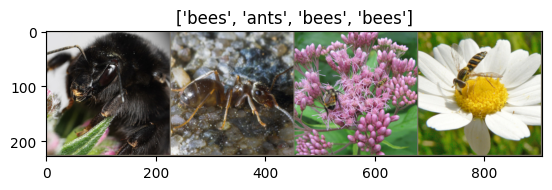

In [201]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# Variational quantum circuit

We first define some quantum layers that will compose the quantum circuit.

In [202]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

Now we define the quantum circuit through the PennyLane qnode decorator .

The structure is that of a typical variational quantum circuit:

- **Embedding layer**: All qubits are first initialized in a balanced superposition of *up* and *down* states, then they are rotated according to the input parameters (local embedding).

- **Variational layers**: A sequence of trainable rotation layers and constant entangling layers is applied.

- **Measurement layer**: For each qubit, the local expectation value of the ***Z*** operator is measured. This produces a classical output vector, suitable for additional post-processing.

In [203]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

Let's visualize this.

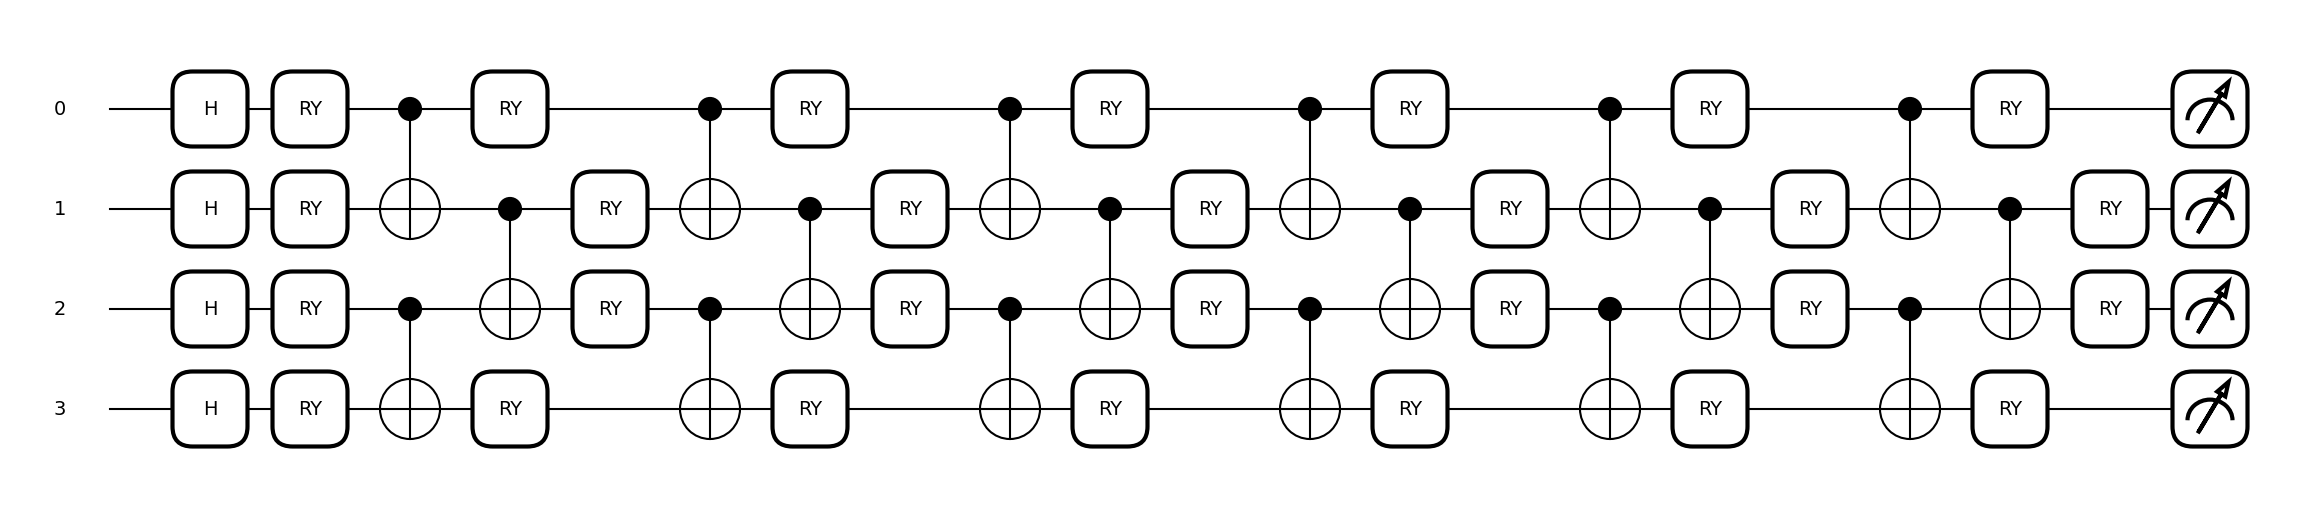

In [204]:
# Dummy inputs
features = np.random.rand(n_qubits)
weights = np.random.rand(q_depth * n_qubits)

# Matplotlib visualization
fig, ax = qml.draw_mpl(quantum_net)(features, weights)
plt.show()

# Dressed quantum circuit

We can now define a custom `torch.nn.Module` representing a *dressed* quantum circuit.

This is a concatenation of:

- A classical pre-processing layer (`nn.Linear`).

- A classical activation function (`torch.tanh`).

- A constant np.pi/2.0 scaling.

- The previously defined quantum circuit (`quantum_net`).

A classical post-processing layer (`nn.Linear`).

The input of the module is a batch of vectors with 512 real parameters (features) and the output is a batch of vectors with two real outputs (associated with the two classes of images: *ants* and *bees*).

Added dropout after pre_net, after post_net, and before tanh

In [205]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits) 
        self.dropout_pre = nn.Dropout(p=0.1)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)
        self.dropout_post = nn.Dropout(p=0.1)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        pre_out = self.dropout_pre(pre_out)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # q_out = self.dropout_post(q_out) NO NEED
        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

# Hybrid classical-quantum model

We are finally ready to build our full hybrid classical-quantum network. We follow the *transfer* learning approach:

1. First load the classical pre-trained network *ResNet18* from the `torchvision.models` zoo.

2. Freeze all the weights since they should not be trained.

3. Replace the last fully connected layer with our trainable dressed quantum circuit (`DressedQuantumNet`).

> **Note**<br>
> The ResNet18 model is automatically downloaded by PyTorch and it may take several minutes (only the first time).

In [206]:
weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
model_hybrid = torchvision.models.resnet18(weights=weights)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

# Training and results

Before training the network we need to specify the *loss* function.

We use, as usual in classification problem, the *cross-entropy* which is directly available within `torch.nn`.



In [207]:
criterion = nn.CrossEntropyLoss()

We also initialize the Adam optimizer which is called at each training step in order to update the weights of the model.

In [208]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

We schedule to reduce the learning rate by a factor of `gamma_lr_scheduler` every 10 epochs.

In [209]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

What follows is a training function that will be called later. This function should return two things:

1. a trained model that can be used to make predictions (classifications)

2. the accuracy of the model on two datasets (training & validation) to see if our model's generalizable (can classify images we didn't use to train it).

In [210]:
# This function trains a PyTorch model and returns the best version + a training history
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()  # Record the starting time of training

    # Save the model's initial weights so we can restore the best version later
    best_model_wts = copy.deepcopy(model.state_dict())

    # Initialize variables to track the best performance
    best_acc = 0.0
    best_loss = float("inf")  # Set to a very high number initially

    # Dictionary to keep track of training and validation loss/accuracy over time
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    print("Training started:\n")

    # Loop through the number of epochs (full passes through the dataset)
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")  # Print current epoch number

        # Each epoch has two phases: training and validation
        for phase in ["train", "validation"]:
            # Set the model to training mode (enables dropout, batchnorm, etc.)
            if phase == "train":
                model.train()
            # Set the model to evaluation mode (turns off dropout, batchnorm, etc.)
            else:
                model.eval()

            # Initialize loss and accuracy counters for this phase
            running_loss = 0.0
            running_corrects = 0

            # Loop over the batches of data
            for inputs, labels in dataloaders[phase]:
                # Move inputs and labels to the GPU (or CPU) device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the gradients so we don't accumulate from previous steps
                optimizer.zero_grad()

                # Enable gradient tracking only in the training phase
                with torch.set_grad_enabled(phase == "train"):
                    # Forward pass: get model predictions
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # Get predicted class
                    loss = criterion(outputs, labels)  # Calculate loss

                    # Backward pass + optimize only if in training phase
                    if phase == "train":
                        loss.backward()      # Compute gradients
                        optimizer.step()     # Update weights

                # Accumulate loss and correct predictions for the entire phase
                running_loss += loss.item() * inputs.size(0)  # Multiply by batch size
                running_corrects += torch.sum(preds == labels.data).item()

            # Calculate average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            # Print the results for this phase
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Save metrics to history and step the scheduler if training
            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
                scheduler.step()  # Adjust learning rate
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)

                # Save the model if this is the best validation accuracy so far
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    # Print total training time
    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")

    # Load the best model weights into the model before returning
    model.load_state_dict(best_model_wts)
    return model, history  # Return the best model and the training history

We are ready to perform the actual training process and store the generalization data.

In [211]:
model_hybrid, history = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:

Epoch 1/3
Train Loss: 0.6931 Acc: 0.5246
Validation Loss: 0.6213 Acc: 0.6993
Epoch 2/3
Train Loss: 0.6112 Acc: 0.6762
Validation Loss: 0.5216 Acc: 0.8235
Epoch 3/3
Train Loss: 0.5235 Acc: 0.8074
Validation Loss: 0.4319 Acc: 0.8824

Training complete in 0m 39s
Best validation accuracy: 0.8824


# Visualizing the model Predications

We first define a visualization function for a batch of test data.

In [212]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

Finally, we can run the previous function to see a batch of images with the corresponding predictions.

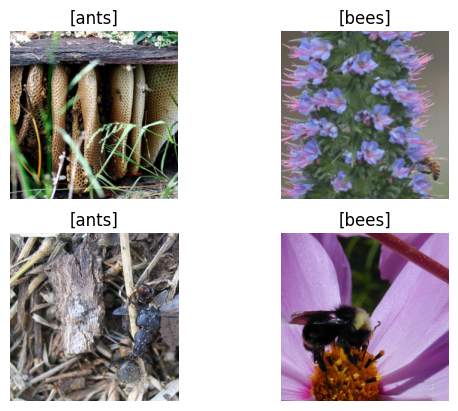

In [213]:
visualize_model(model_hybrid, num_images=batch_size)
plt.show()

# References
[1] Andrea Mari, Thomas R. Bromley, Josh Izaac, Maria Schuld, and Nathan Killoran. Transfer learning in hybrid classical-quantum neural networks. arXiv:1912.08278 (2019).

[2] Rajat Raina, Alexis Battle, Honglak Lee, Benjamin Packer, and Andrew Y Ng. Self-taught learning: transfer learning from unlabeled data. Proceedings of the 24th International Conference on Machine Learning*, 759–766 (2007).

[3] Kaiming He, Xiangyu Zhang, Shaoqing ren and Jian Sun. Deep residual learning for image recognition. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 770-778 (2016).

[4] Ville Bergholm, Josh Izaac, Maria Schuld, Christian Gogolin, Carsten Blank, Keri McKiernan, and Nathan Killoran. PennyLane: Automatic differentiation of hybrid quantum-classical computations. arXiv:1811.04968 (2018).

[5] Andrea Mari. Quantum Transfer Learning. https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning (2024)